## Randomized Search with Hyperopt

In this notebook, we will perform **Randomized Search** to select the best **hyperparameters** for a Gradient Boosting Classifier, using the open source Python package [Hyperopt](http://hyperopt.github.io/hyperopt/).

The randomized search is performed with the class **rand**.

I find the documentation for Hyperopt quite unintuitive, so it helps to refer to the [original article](https://iopscience.iop.org/article/10.1088/1749-4699/8/1/014008/pdf) to understand the different parameters and classes.

To step out of Scikit-learn, we will optimise the parameters of a Gradient Boosting Machine of the [xgboost package](https://xgboost.readthedocs.io/en/latest/python/python_intro.html).


### Procedure

To tune the hyper-parameters of our model we need to:

- define a model
- define the hyperparameter space
- define the objective function we want to minimize.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

import xgboost as xgb

from hyperopt import hp, rand, fmin, Trials

# hp: define the hyperparameter space
# rand: random search
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters

In [2]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
Name: count, dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the Hyperparameter Space

- [Hyperopt search space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

- [xgb.XGBClassifier hyperparameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)

- [xgb general parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [5]:
# determine the hyperparameter space

param_grid = {
    'n_estimators': hp.quniform('n_estimators', 200, 2500, 100), # min, max, step
    'max_depth': hp.uniform('max_depth', 1, 10), # min, max
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.99),
    'booster': hp.choice('booster', ['gbtree', 'dart']),
    'gamma': hp.quniform('gamma', 0.01, 10, 0.1),
    'subsample': hp.uniform('subsample', 0.50, 0.90),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.50, 0.99),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.50, 0.99),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.50, 0.99),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [6]:
# the objective function takes the hyperparameter space
# as input

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    # here, we capture one parameter from the distributions
    params_dict = {
        'n_estimators': int(params['n_estimators']), # important int, as it takes integers only
        'max_depth': int(params['max_depth']), # important int, as it takes integers only
        'learning_rate': params['learning_rate'],
        'booster': params['booster'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'colsample_bylevel': params['colsample_bylevel'],
        'colsample_bynode': params['colsample_bynode'],
        'random_state': 1000,
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    gbm = xgb.XGBClassifier(**params_dict)

    # train with cv
    score = cross_val_score(gbm, X_train, y_train,
                            scoring='accuracy', cv=5, n_jobs=4).mean()

    # to minimize, we negate the score
    return -score

## Randomized Search

[fmin](http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/)

In [7]:
# fmin performs the minimization
# rand.suggest samples the parameters at random
# i.e., performs the random search
# NOTE: I got the error "AttributeError: 'numpy.random._generator.Generator' object has no attribute 'randint'"
# So I needed to replace randint() with integers() in fmin.py
search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50, # number of combinations we'd like to randomly test
    rstate=np.random.default_rng(42),
    algo=rand.suggest,  # randomized search
)

100%|██████| 50/50 [1:01:21<00:00, 73.62s/trial, best loss: -0.967373417721519]


In [8]:
# fmin returns a dictionary with the best parameters
type(search)

dict

In [9]:
# best hyperparameters
search

{'booster': 0,
 'colsample_bylevel': 0.5417218082785964,
 'colsample_bynode': 0.6360624477042073,
 'colsample_bytree': 0.9634914672712649,
 'gamma': 3.4000000000000004,
 'learning_rate': 0.8373466315069332,
 'max_depth': 8.014045097149003,
 'n_estimators': 900.0,
 'reg_lambda': 4.390033483723911,
 'subsample': 0.5507691346710539}

In [10]:
# create another dictionary to pass the search items as parameters
# to a new xgb
# we basically grab the best hyperparameters here and assure that the types
# are correct
best_hp_dict = {
        'n_estimators': int(search['n_estimators']), # important int, as it takes integers only
        'max_depth': int(search['max_depth']), # important int, as it takes integers only
        'learning_rate': search['learning_rate'],
        'booster': 'gbtree',
        'gamma': search['gamma'],
        'subsample': search['subsample'],
        'colsample_bytree': search['colsample_bytree'],
        'colsample_bylevel': search['colsample_bylevel'],
        'colsample_bynode': search['colsample_bynode'],
        'random_state': 1000,
}

In [11]:
# after the search we can train the model with the
# best parameters manually
gbm_final = xgb.XGBClassifier(**best_hp_dict)
gbm_final.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5417218082785964,
              colsample_bynode=0.6360624477042073,
              colsample_bytree=0.9634914672712649, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.4000000000000004, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.8373466315069332, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=900, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1000, ...)

In [12]:
# Final score on train and test splits
X_train_preds = gbm_final.predict(X_train)
X_test_preds = gbm_final.predict(X_test)
print('Train accuracy: ', accuracy_score(y_train, X_train_preds))
print('Test accuracy: ', accuracy_score(y_test, X_test_preds))

Train accuracy:  0.992462311557789
Test accuracy:  0.9766081871345029


## Evaluating the search

We can use Trials if we want to look into the search, and the performance values encountered during the process.

In [13]:
# We can use the Trials() object to store more information from the search
# for later inspection
trials = Trials()

In [14]:
second_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=rand.suggest,  # randomized search
    trials=trials
)

100%|██████| 50/50 [1:16:37<00:00, 91.94s/trial, best loss: -0.967373417721519]


In [15]:
# best hyperparameters
second_search

{'booster': 0,
 'colsample_bylevel': 0.5417218082785964,
 'colsample_bynode': 0.6360624477042073,
 'colsample_bytree': 0.9634914672712649,
 'gamma': 3.4000000000000004,
 'learning_rate': 0.8373466315069332,
 'max_depth': 8.014045097149003,
 'n_estimators': 900.0,
 'reg_lambda': 4.390033483723911,
 'subsample': 0.5507691346710539}

In [16]:
# the best hyperparameters can also be found in
# trials
trials.argmin

{'booster': 0,
 'colsample_bylevel': 0.5417218082785964,
 'colsample_bynode': 0.6360624477042073,
 'colsample_bytree': 0.9634914672712649,
 'gamma': 3.4000000000000004,
 'learning_rate': 0.8373466315069332,
 'max_depth': 8.014045097149003,
 'n_estimators': 900.0,
 'reg_lambda': 4.390033483723911,
 'subsample': 0.5507691346710539}

In [17]:
# the search hyperparameter combinations
pd.DataFrame(trials.vals).head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_lambda,subsample
0,1,0.855670,0.528190,0.869778,4.8,0.601237,9.940792,1500.0,9.501192,0.818971
1,0,0.930921,0.797359,0.811225,7.7,0.084919,3.422783,1100.0,19.340523,0.724776
2,0,0.746456,0.551347,0.685468,7.5,0.879731,6.709789,2100.0,7.766250,0.580990
3,1,0.529457,0.971754,0.732098,6.5,0.232582,8.511571,1600.0,6.651584,0.708844
4,1,0.851329,0.707479,0.746306,0.5,0.204150,8.298477,900.0,7.866093,0.620886


In [18]:
# the results
pd.DataFrame(trials.results).head()

,loss,status
0,-0.952215,ok
1,-0.942215,ok
2,-0.944778,ok
3,-0.947278,ok
4,-0.959810,ok


In [19]:
# All the results, sorted by loss = minimized score
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_lambda,subsample,loss,status
0,0,0.841511,0.597925,0.835442,7.6,0.876538,7.305502,1200.0,11.549471,0.527112,-0.932215,ok
1,1,0.978227,0.791916,0.764511,8.9,0.764173,7.316458,1900.0,6.781077,0.634386,-0.932215,ok
2,1,0.794350,0.579017,0.719781,5.6,0.905261,6.933093,800.0,18.178009,0.772806,-0.934652,ok
3,1,0.553077,0.513661,0.879695,8.5,0.643556,3.544019,800.0,19.736914,0.737161,-0.939715,ok
4,1,0.705796,0.874990,0.537095,7.3,0.149988,2.689795,1000.0,3.955595,0.569747,-0.939715,ok


Text(0.5, 0, 'Hyperparam combination')

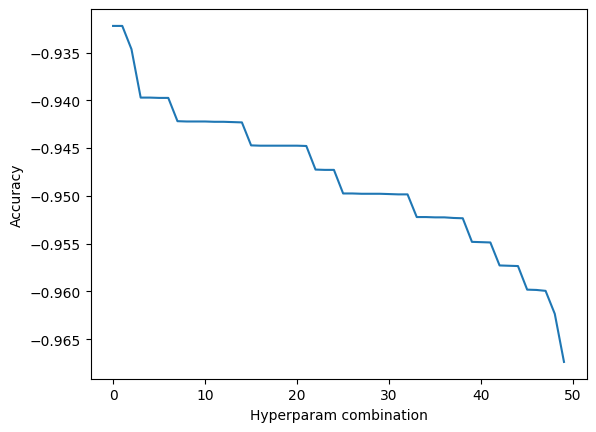

In [20]:
# Plot the score as function of the hyperparameter combination
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

In [22]:
# Minimum/best score (recall we minimize)
pd.DataFrame(trials.results)['loss'].min()

-0.9674050632911392